<a href="https://colab.research.google.com/github/Pekay27/Maximizing-Scarce-Maintenance-Resources/blob/master/Copy_of_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

.0Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


In [7]:
# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


In [9]:
# transform status group into binary encoding 'functional' and 'non functional' 
df['needs_to_repair'] = df['status_group'].apply(lambda x : 0 if x == 'functional' else 1)
X = df.drop(['needs_to_repair', 'status_group'], axis=1)
y = df['needs_to_repair']

In [10]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Make pipeline!
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=90, max_depth=25, max_features='auto', random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8262626262626263


In [ ]:
# ran the cell below in another notebook, ran for 60mins, 
# decided to hard code best params from the gridsearch 
# now lets tune model by using GridSearchCV
# first create a dictionary of hyperparameters that
# I want to tune in the GridSearch, and the values/increments in which to do it

#params = {'randomforestclassifier__n_estimators': np.arange(90,131,20),
          'randomforestclassifier__max_depth': np.arange(15,35,10),
          'randomforestclassifier__max_features': np.arange(13,23,3),
          'randomforestclassifier__max_samples': np.arange(0.3, 0.51, 0.1)}
# create model using rf & gs

# rf_gs= GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=1)

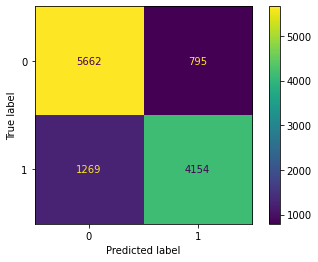

In [15]:
# Plot a confusion matrix for your Tanzania Waterpumps model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f')

In [17]:
# check all scores
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.816910  0.876878  0.845832      6457
           1   0.839361  0.765997  0.801003      5423

    accuracy                       0.826263     11880
   macro avg   0.828136  0.821437  0.823417     11880
weighted avg   0.827158  0.826263  0.825368     11880



In [19]:
# create PR curve and PR Score
# predicted probabilities 
pipeline.predict_proba(X_val)
# predicted probs for positive class
y_pred_prob = pipeline.predict_proba(X_val)[:,1]

In [21]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_prob), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

In [24]:
recall_remove_last = recall[:-1]
precision_remove_last = precision[:-1]

In [25]:
# See the results in a table
pd.DataFrame({
    'Precision': precision_remove_last, 
    'Recall': recall_remove_last, 
    'Threshold': thresholds

})

,Precision,Recall,Threshold
0,0.456481,1.000000,0.000000
1,0.461591,0.999447,0.000048
2,0.461630,0.999447,0.000066
3,0.461984,0.999447,0.000096
4,0.462063,0.999447,0.000122
...,...,...,...
7688,0.984334,0.069519,0.999790
7689,0.986877,0.069334,0.999882
7690,0.986702,0.068412,0.999918
7691,0.986595,0.067859,0.999978


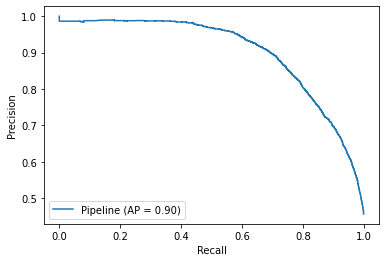

In [27]:
plot_precision_recall_curve(pipeline, X_val, y_val)

In [28]:
# Use AUC function to calculate the area under the curve of precision recall curve
from sklearn.metrics import auc
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.902350832353638
